In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing

import sys
sys.path.append("..")
from helpers import filename_for

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
class DataGeneratorBars(keras.utils.Sequence):
    def __init__(self, config):
        self.c = config

        self.labels = []
        self.features = []

        self.scaler_tri = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_e = sklearn.preprocessing.MaxAbsScaler()
        self.scaler_t = sklearn.preprocessing.MaxAbsScaler()

        file = filename_for(
            self.c["distance"],
            self.c["doubleplane"],
            self.c["energy"],
            self.c["erel"],
            self.c["neutrons"][0],
            "inclxx",
            self.c["subruns"][0],
            "bars.parquet",
        )
        data = pd.read_parquet(file)
        rows = len(data.index)
        del data

        self.batches_per_subrun = (rows * len(self.c["neutrons"])) // self.c["batch_size"]
        self.batches_per_cache = self.batches_per_subrun * self.c["subrun_cache_size"]
        self.len = self.batches_per_subrun * len(self.c["subruns"])

        self.cache_subruns = [
            self.c["subruns"][i : i + self.c["subrun_cache_size"]]
            for i in range(0, len(self.c["subruns"]), self.c["subrun_cache_size"])
        ]
        self.current_cache = -1

        print(f"Rows in one file: {rows}")
        print(f"{self.batches_per_subrun} batches per subrun")
        print(f"{self.len} total batches in {self.cache_subruns} caches")

        self.fitscalers()
        self.load(0)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        cacheid = index // self.batches_per_cache
        i = index % (self.batches_per_cache)
        # print(f"{index} -> c{cacheid}-i{i}")

        if cacheid != self.current_cache:
            self.load(cacheid)

        a = i * self.c["batch_size"]
        b = (i + 1) * self.c["batch_size"]

        x = self.features[a:b]
        y = self.labels[a:b]
        return x, y

    def load(self, cacheid):
        subruns = self.cache_subruns[cacheid]
        print(f"Loading subruns {subruns} for cache {cacheid}")

        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True).sample(frac=1)
        data.loc[data["nHits"] == 0, self.c["label"]] = 0

        self.current_cache = cacheid
        self.features = np.concatenate(
            (
                self.scaler_tri.transform(data[self.c["cols_tri"]]),
                self.scaler_e.transform(data[self.c["cols_e"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_e"])
                ),
                self.scaler_t.transform(data[self.c["cols_t"]].values.reshape(-1, 1)).reshape(
                    -1, len(self.c["cols_t"])
                ),
            ),
            axis=1,
        )
        self.labels = keras.utils.to_categorical(
            data[[self.c["label"]]].values.ravel(), num_classes=len(self.c["neutrons"]) + 1
        )
        del data

    def fitscalers(self):
        subruns = range(5)  # self.cache_subruns[0]
        files = [
            filename_for(
                self.c["distance"],
                self.c["doubleplane"],
                self.c["energy"],
                self.c["erel"],
                n,
                "inclxx",
                subrun,
                "bars.parquet",
            )
            for n in self.c["neutrons"]
            for subrun in subruns
        ]
        data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)
        self.scaler_tri.fit(data[self.c["cols_tri"]])
        self.scaler_e.fit(data[self.c["cols_e"]].values.reshape(-1, 1))
        self.scaler_t.fit(data[self.c["cols_t"]].values.reshape(-1, 1))
        del data

In [4]:
config = {
    "distance": 15,
    "doubleplane": 30,
    "energy": 600,
    "erel": 500,
    "neutrons": [1, 2, 3, 4],
    "subruns": range(7),  # range(19),
    "subrun_cache_size": 7,
    "batch_size": 200,
    "cols_tri": ["nHits", "nClus", "Edep"],
    "cols_e": [str(i) for i in range(0, 30 * 100 * 2, 2)],
    "cols_t": [str(i + 1) for i in range(0, 30 * 100 * 2, 2)],
    "label": "nPN",
}

validation_config = config.copy()
validation_config["subruns"] = [19]

In [5]:
generator = DataGeneratorBars(config)
validation_generator = DataGeneratorBars(validation_config)

Rows in one file: 10000
200 batches per subrun
1400 total batches in [range(0, 7)] caches
Loading subruns range(0, 7) for cache 0
Rows in one file: 10000
200 batches per subrun
200 total batches in [[19]] caches
Loading subruns [19] for cache 0


In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=10000, activation="relu"))
model.add(keras.layers.Dense(units=100, activation="relu"))
model.add(keras.layers.Dense(units=len(config["neutrons"]) + 1, activation="softmax"))
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

In [7]:
history = model.fit(generator, verbose=2, epochs=10, shuffle=False, validation_data=validation_generator)

Epoch 1/10
1400/1400 - 65s - loss: 0.6682 - accuracy: 0.7085 - val_loss: 0.6395 - val_accuracy: 0.7184
Epoch 2/10
1400/1400 - 65s - loss: 0.6049 - accuracy: 0.7354 - val_loss: 0.6248 - val_accuracy: 0.7269
Epoch 3/10
1400/1400 - 75s - loss: 0.5352 - accuracy: 0.7711 - val_loss: 0.6680 - val_accuracy: 0.7165
Epoch 4/10
1400/1400 - 72s - loss: 0.4036 - accuracy: 0.8378 - val_loss: 0.8331 - val_accuracy: 0.7034
Epoch 5/10
1400/1400 - 74s - loss: 0.2719 - accuracy: 0.8979 - val_loss: 1.2611 - val_accuracy: 0.6664
Epoch 6/10
1400/1400 - 67s - loss: 0.1797 - accuracy: 0.9355 - val_loss: 1.2599 - val_accuracy: 0.6984
Epoch 7/10
1400/1400 - 74s - loss: 0.1160 - accuracy: 0.9606 - val_loss: 1.4361 - val_accuracy: 0.6894
Epoch 8/10
1400/1400 - 79s - loss: 0.0742 - accuracy: 0.9758 - val_loss: 1.6205 - val_accuracy: 0.6849
Epoch 9/10
1400/1400 - 74s - loss: 0.0568 - accuracy: 0.9819 - val_loss: 1.8637 - val_accuracy: 0.6662
Epoch 10/10
1400/1400 - 69s - loss: 0.0495 - accuracy: 0.9842 - val_loss:

In [8]:
del generator
del validation_generator

In [10]:
test_config = config.copy()
test_config["subruns"] = range(7, 9) #11)
test_generator = DataGeneratorBars(test_config)

Rows in one file: 10000
200 batches per subrun
400 total batches in [range(7, 9)] caches
Loading subruns range(7, 9) for cache 0


In [11]:
X = test_generator.features
y_true = np.argmax(test_generator.labels, axis=1)
y_pred = np.argmax(model.predict(X), axis=1)

In [12]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
print((cmrel * 100).round())

0.7447027621655318
[[ 1038     0     0     0     0]
 [    0 18088   742   169    11]
 [    0  4333  9556  5671   395]
 [    0   577  2920 11615  4885]
 [    0    63   523  5168 14246]]
[[100.   0.   0.   0.   0.]
 [  0.  95.   4.   1.   0.]
 [  0.  22.  48.  28.   2.]
 [  0.   3.  15.  58.  24.]
 [  0.   0.   3.  26.  71.]]


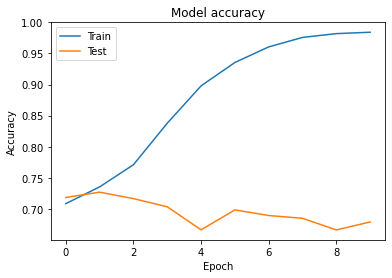

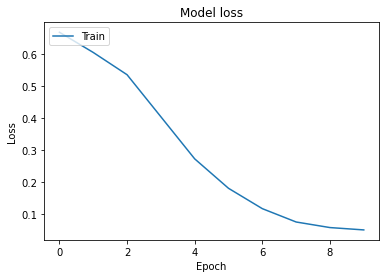

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()